In [79]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time

In [51]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [3]:
dataset=mfp.get_manta_files()

total:1801
labelled:295


In [12]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [13]:
image_size=[100,100]
heatmap_size=[17,17]

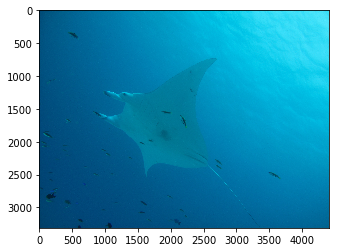

In [48]:
image = Image.open(im_path)
plt.imshow(image)

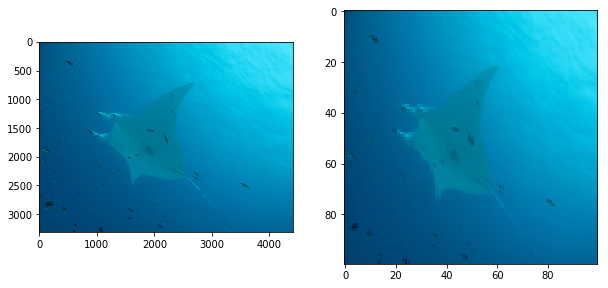

In [105]:
im_path,blm_path = manta_data[3]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)


fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image=mfp.image_to_numpy(image,image_size)
axes[1].imshow(image)    
#axes[2].imshow(image[:,::-1])   
plt.show()


In [53]:
X=[]
y=[]
i=0
print ("total:" + str(manta_data.shape[0]))

for im_path,blm_path in manta_data:#[:20]:
    try:
        image = Image.open(im_path)
        body_landmarks=mfp.extract_body_landmarks(blm_path)
    except:
        print(" \n Error on "+blm_path)
        
    image=mfp.image_to_numpy(image,image_size)
    heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)
    numpy_heatmaps=mfp.heatmaps_to_numpy(heatmaps)
    
    if image.shape[2]>3:
        print("\n More then 3 channels")
        print(blm_path)
        numpy_heatmaps=None
    
    if numpy_heatmaps is not None and numpy_heatmaps.sum()>0:
        y.append(numpy_heatmaps.reshape([heatmap_size[0],heatmap_size[1],1]))
        X.append(image) 
    print(i,end=" ")
    i+=1

X=np.array(X)
y=np.array(y)
print("\n====================")
print("Done.\nX.shape="+str(X.shape))
print("y.shape="+str(y.shape))


total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 
 More then 3 channels
C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0353 Candy\353-F-20150624-PM-LEI-MichelleOoi-CANDY.json
126 127 128 129 130 131 132 
 More then 3 channels
C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0042 Ellama\42-F-20150906-LEI-ChrisGarraway-ELLAMA.json
133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 
 More then 3 channels
C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0003 Isabell

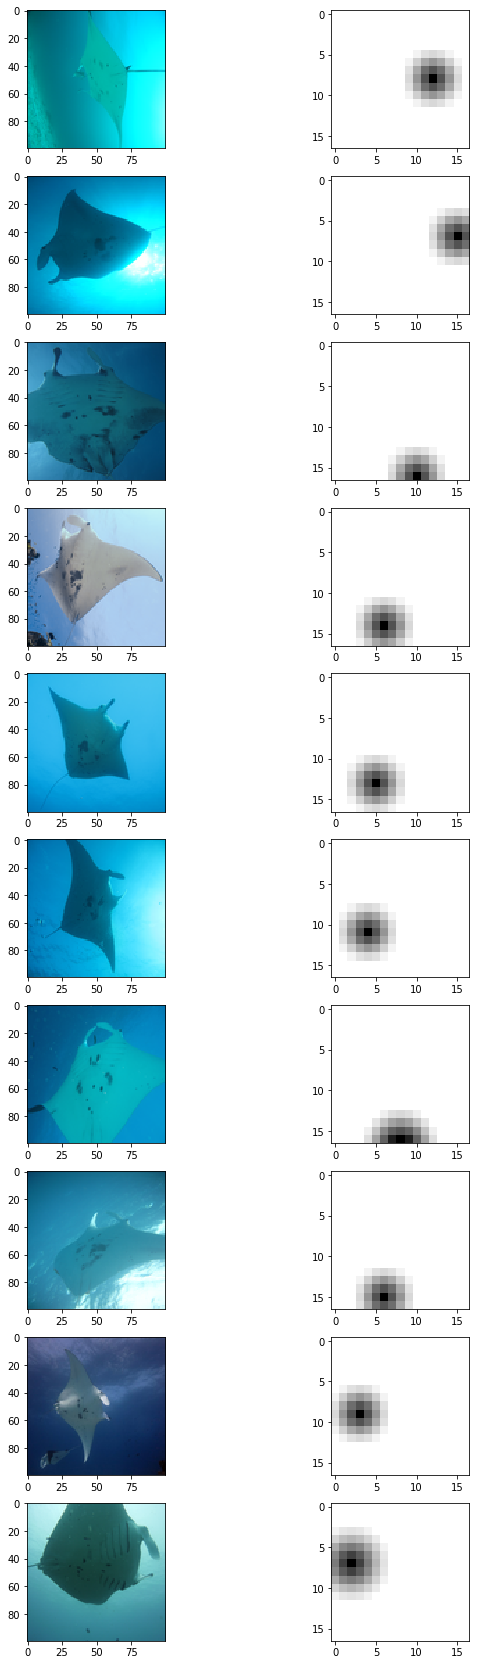

In [90]:
import random
n=10
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(X[s])
    axes[i,1].imshow(y[s][:,:,0],cmap='Greys')
plt.show()


In [54]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [86]:
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
batch_size=8
nb_train_samples=int(round(X.shape[0]*0.9,0))
X_train=X[:nb_train_samples]
X_test =X[nb_train_samples:]
y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [64]:
#pip install h5py
#pip install cython
#restart jupyther
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False
vgg16_net.summary()

#from tensorflow.keras.models import Model
#mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[n_layer].get_output_at(0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [57]:
model=Sequential()
model.add(vgg16_net)

model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=1,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 512)         2048      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 64)          294976    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 15, 15, 32)        18464     
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 17, 17, 1)         289       
__________

In [102]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

Epoch 1/200
241/241 [==============================] - 11s 44ms/step - loss: 0.0855 - binary_accuracy: 0.8717
Epoch 2/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0854 - binary_accuracy: 0.8717
Epoch 3/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0847 - binary_accuracy: 0.8717
Epoch 4/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0844 - binary_accuracy: 0.8717
Epoch 5/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0843 - binary_accuracy: 0.8717
Epoch 6/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0840 - binary_accuracy: 0.8717
Epoch 7/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0841 - binary_accuracy: 0.8717
Epoch 8/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0840 - binary_accuracy: 0.8717
Epoch 9/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0837 - binary_accuracy: 0.8717
Epoch 10/200
241/2

241/241 [==============================] - 5s 22ms/step - loss: 0.0782 - binary_accuracy: 0.8717
Epoch 76/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0783 - binary_accuracy: 0.8717
Epoch 77/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0782 - binary_accuracy: 0.8717
Epoch 78/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0784 - binary_accuracy: 0.8717
Epoch 79/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0782 - binary_accuracy: 0.8717
Epoch 80/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0781 - binary_accuracy: 0.8717
Epoch 81/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0780 - binary_accuracy: 0.8717
Epoch 82/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0781 - binary_accuracy: 0.8717
Epoch 83/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0780 - binary_accuracy: 0.8717
Epoch 84/200
241/241 [=

241/241 [==============================] - 5s 22ms/step - loss: 0.0782 - binary_accuracy: 0.8716
Epoch 150/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0786 - binary_accuracy: 0.8716
Epoch 151/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0776 - binary_accuracy: 0.8717
Epoch 152/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0772 - binary_accuracy: 0.8717
Epoch 153/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0771 - binary_accuracy: 0.8717
Epoch 154/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0770 - binary_accuracy: 0.8717
Epoch 155/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0767 - binary_accuracy: 0.8717
Epoch 156/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0771 - binary_accuracy: 0.8717
Epoch 157/200
241/241 [==============================] - 5s 22ms/step - loss: 0.0769 - binary_accuracy: 0.8717
Epoch 158/200
2

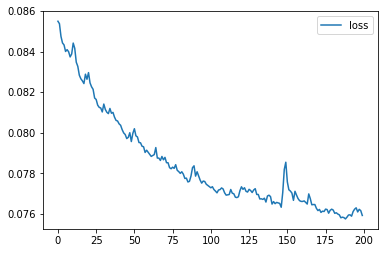

In [81]:
start_time = time.time()

history=model.fit(X_train,y_train,batch_size=16,epochs=200)

print("\nTraining time in seconds:'--- %s seconds ---" % (time.time() - start_time))

loss = history.history['loss']
plt.plot(loss)
plt.legend(['loss'])
plt.show()

In [87]:
pred=model.predict(X_test)
X_test.shape

(27, 100, 100, 3)

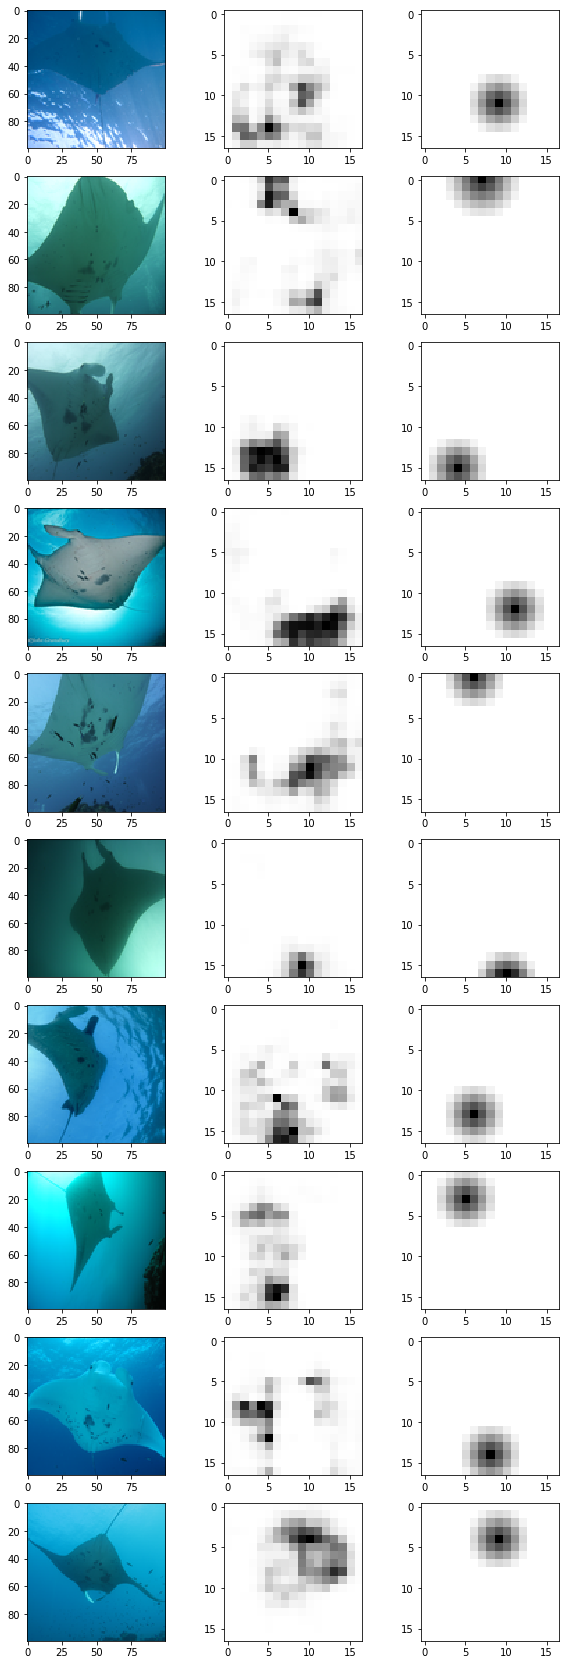

In [103]:
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=3,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(X_test[s])
    axes[i,1].imshow(pred[s][:,:,0],cmap='Greys')
    axes[i,2].imshow(y_test[s][:,:,0],cmap='Greys')
plt.show()